In [1]:
pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=1aa13e763d9bc3b7f2ec5b1588914831db4521b12d48ed86f8931a75fbd2be6f
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import math
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow import keras
from tensorflow.keras import regularizers

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations
from scipy.interpolate import griddata
#from eager_lbfgs import lbfgs, Struct
from pyDOE import lhs
import sys

DTYPE='float32'
tf.random.set_seed(1234)
np.random.seed(seed=1234)


In [58]:
class CustomNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-8, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        lb_main = np.array([0.0, 0.0])
        ub_main = np.array([1.0, 1.0])
        inputs = 2*(inputs - lb_main)/(ub_main - lb_main) - 1
        return inputs

class FourierFeaturesLayer(tf.keras.layers.Layer):
    def __init__(self, num_features, scale=10.0, **kwargs):
        super(FourierFeaturesLayer, self).__init__(**kwargs)
        self.num_features = num_features
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name='B', shape=(input_shape[-1], self.num_features),
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=True)

    def call(self, inputs):
        x_proj = 2.0 * np.pi * tf.matmul(inputs, self.B)
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

class CustomSineCosineActivation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomSineCosineActivation, self).__init__(**kwargs)
        self.A = self.add_weight(name='A', shape=(1,), initializer='ones', trainable=True)
        self.B = self.add_weight(name='B', shape=(1,), initializer='ones', trainable=True)
        self.C = self.add_weight(name='C', shape=(1,), initializer='ones', trainable=True)
        self.D = self.add_weight(name='D', shape=(1,), initializer='ones', trainable=True)
        self.E = self.add_weight(name='E', shape=(1,), initializer='ones', trainable=True)
        self.F = self.add_weight(name='F', shape=(1,), initializer='ones', trainable=True)
    def call(self, inputs):
        return self.A * tf.sin(self.B*inputs) + self.C * tf.cos(self.D*inputs)+ self.E * tf.tanh(self.F*inputs)



class H_PINN(tf.keras.Model):
    def __init__(self, num_fourier_features=64):
        super(H_PINN, self).__init__()
        self.norm1 = CustomNormalization()
        l2_factor = 0.01
        self.input_projection = tf.keras.layers.Dense(100, use_bias=False)
        self.dense1 = tf.keras.layers.Dense(100, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(l2_factor))
        self.custom_activation1 = CustomSineCosineActivation()
        self.dense2 = tf.keras.layers.Dense(100, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(l2_factor))
        self.custom_activation2 = CustomSineCosineActivation()
        self.dense3 = tf.keras.layers.Dense(100, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(l2_factor))
        self.custom_activation3 = CustomSineCosineActivation()
        self.fourier = FourierFeaturesLayer(num_features=num_fourier_features)
        self.output_layer = tf.keras.layers.Dense(1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(l2_factor))

    def call(self, inputs):
        x = self.norm1(inputs)
        projected_x = self.input_projection(x)

        x1 = self.dense1(projected_x)
        x1_activated = self.custom_activation1(x1)
        x2_input = x1_activated + projected_x

        x2 = self.dense2(x2_input)
        x2_activated = self.custom_activation2(x2)
        x3_input = x2_activated + projected_x

        x3 = self.dense3(x3_input)
        x3 = x3 + projected_x
        x3_activated = self.custom_activation3(x3)
        x_out = self.output_layer(x3_activated)

        return x_out





In [59]:

u_model = H_PINN()
input_shape = (2,1)
u_model.build(input_shape)
u_model.summary()

@tf.function
def f_model(x, t):
    u = u_model(tf.concat([x,t], 1))
    u_x = tf.gradients(u,x)[0]
    u_t = tf.gradients(u,t)[0]
    u_xx = tf.gradients(u_x,x)[0]
    S = tf.exp(-t)*tf.sin(math.pi*x)*(1+math.pi**2)
    f = u_t - u_xx - S
    f_x = tf.gradients(f,x)[0]
    return f, f_x

@tf.function
def u_x_model(x,t):
    u = u_model(tf.concat([x,t], 1))
    return u



def loss(x_f, t_f, x_0, t_0, x_lb, t_lb, x_rb, t_rb, w1, w2, w3):

    f_u_pred, f_x = f_model(x_f, t_f)
    u_lb = u_x_model(x_lb, t_lb)
    u_rb = u_x_model(x_rb, t_rb)
    u_0 = u_x_model(x_0, t_0)

    mse_u_0 = tf.reduce_mean(tf.square(u_0-tf.math.sin(math.pi*x_0)))
    mse_b_u = tf.reduce_mean(tf.square(w1*u_lb)) + tf.reduce_mean(tf.square(w2*u_rb))


    mse_f_u = tf.reduce_mean(tf.square(w3*f_u_pred))
    mse_f_x = tf.reduce_mean(tf.square(f_x))


    return  mse_b_u + mse_f_u , mse_f_u


loss_vals = []

@tf.function
def grad(model, x_f, t_f, x_0, t_0,  x_lb, t_lb, x_rb, t_rb, w1, w2, w3):
    with tf.GradientTape(persistent=True) as tape:
        loss_value, mse_f = loss(x_f, t_f, x_0, t_0, x_lb, t_lb, x_rb, t_rb, w1, w2, w3)
        grads = tape.gradient(loss_value, u_model.trainable_variables)

        grads_w1 = tape.gradient(loss_value, w1)
        grads_w2 = tape.gradient(loss_value, w2)
        grads_w3 = tape.gradient(loss_value, w3)




    return loss_value, grads, grads_w1, grads_w2, grads_w3


#@tf.function
def fit(x_f, t_f, x_0, t_0, x_lb, t_lb, x_rb, t_rb, w1, w2, w3, tf_iter):

    n_batches =  1
    start_time = time.time()
    tf_optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1=.99, name="Adam")#tf.keras.optimizers.Adam

    tf_optimizer_w1 =  tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=.99, name="Adam")#tf.keras.optimizers.Adam
    tf_optimizer_w2 =  tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=.99, name="Adam")#tf.keras.optimizers.Adam
    tf_optimizer_w3 =  tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=.99, name="Adam")#tf.keras.optimizers.Adam
    tf_optimizer_w4 =  tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=.99, name="Adam")#tf.keras.optimizers.Adam


    print("starting Adam training")

    for epoch in range(tf_iter):
        for i in range(n_batches):


            loss_value, grads, grads_w1, grads_w2, grads_w3 = grad(u_model, x_f, t_f, x_0, t_0, x_lb, t_lb, x_rb, t_rb, w1, w2, w3)

            tf_optimizer.apply_gradients(zip(grads, u_model.trainable_variables))

            tf_optimizer_w1.apply_gradients(zip([-grads_w1], [w1]))
            tf_optimizer_w2.apply_gradients(zip([-grads_w2], [w2]))
            tf_optimizer_w3.apply_gradients(zip([-grads_w3], [w3]))


            loss_vals.append(loss_value.numpy())

        if epoch % 1000 == 0:
            elapsed = time.time() - start_time
            print('It: %d, Time: %.2f' % (epoch, elapsed))
            tf.print(f"total loss: {loss_value}")

            start_time = time.time()



def predict_u0(X_star):
    X_star = tf.convert_to_tensor(X_star, dtype=tf.float32)
    u_star = u_x_model(X_star[:,0:1], X_star[:,1:2])
    f_u_star = f_model(X_star[:,0:1], X_star[:,1:2])

    return u_star







Model: "h_pinn_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_normalization_9 (Cu  multiple                  0         
 stomNormalization)                                              
                                                                 
 dense_44 (Dense)            multiple                  200       
                                                                 
 dense_45 (Dense)            multiple                  10100     
                                                                 
 custom_sine_cosine_activat  multiple                  6         
 ion_27 (CustomSineCosineAc                                      
 tivation)                                                       
                                                                 
 dense_46 (Dense)            multiple                  10100     
                                                          

In [60]:
# Define Points

Nf = 25000
N0 = 500
N_b = 500
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])


# Interior points

X_f = lb + (ub-lb)*lhs(2, Nf)

x = np.linspace(0.0,1.0,200).flatten()[:,None]
t = np.linspace(0.0,1.0,2500).flatten()[:,None]


# Initial Points
idx0 = np.random.randint((x.shape[0],t.shape[0]), size=(N0,2))
x0 = x[idx0[:,0],:]
X0 = np.concatenate((x0, 0*x0), 1)

# Boundary points
idx0_t = np.random.randint((x.shape[0], t.shape[0]), size=(N_b,2))
tb0 = t[idx0_t[:,1],:]
xb0 = x[idx0_t[:,0],:]

X_lb = np.concatenate((0*xb0 + lb[0], tb0), 1) # [0, t]
X_rb = np.concatenate((0*xb0 + ub[0], tb0), 1) # [0, t]



#Convert to tf variables



x_0 = tf.convert_to_tensor(X0[:,0:1], dtype=tf.float32)
t_0 = tf.convert_to_tensor(X0[:,1:2], dtype=tf.float32)

x_lb = tf.convert_to_tensor(X_lb[:,0:1], dtype=tf.float32)
t_lb = tf.convert_to_tensor(X_lb[:,1:2], dtype=tf.float32)

x_rb = tf.convert_to_tensor(X_rb[:,0:1], dtype=tf.float32)
t_rb = tf.convert_to_tensor(X_rb[:,1:2], dtype=tf.float32)

x_f = tf.convert_to_tensor(X_f[:,0:1], dtype=tf.float32)
t_f = tf.convert_to_tensor(X_f[:,1:2], dtype=tf.float32)

w1 = tf.Variable(tf.reshape(tf.repeat(100.0, N0),(N0, -1)),trainable=True)
w2 = tf.Variable(tf.reshape(tf.repeat(100.0, N0),(N0, -1)),trainable=True)
w3 = tf.Variable(tf.reshape(tf.repeat(100.0, Nf),(Nf, -1)),trainable=True)









In [61]:
print('##################################################################### Starting ##########################################################################################')
# x_f, t_f, x_0, t_0, x_lb, t_lb, x_rb, t_rb, w1, w2, w3
fit(x_f, t_f, x_0, t_0, x_lb, t_lb, x_rb, t_rb, w1, w2, w3, tf_iter = 10000)

print('################################################################## Sucessfully Done #####################################################################################')


##################################################################### Starting ##########################################################################################
starting Adam training
It: 0, Time: 30.02
total loss: 1052049.5
It: 1000, Time: 70.52
total loss: 16.83155059814453
It: 2000, Time: 70.56
total loss: 3.6821582317352295
It: 3000, Time: 70.48
total loss: 1.5322765111923218
It: 4000, Time: 70.51
total loss: 0.629061222076416
It: 5000, Time: 70.53
total loss: 0.3075172007083893
It: 6000, Time: 70.55
total loss: 0.18803203105926514
It: 7000, Time: 70.53
total loss: 0.11817948520183563
It: 8000, Time: 70.52
total loss: 0.07231587171554565
It: 9000, Time: 70.53
total loss: 0.4083329439163208
################################################################## Sucessfully Done #####################################################################################


In [62]:
u_model.save("tau1_model")

In [64]:
# Predict

x = np.linspace(0.0,1.0,100).flatten()[:,None]
t = np.linspace(0.0,1.0,2500).flatten()[:,None]
dt = 0.0004


X, Y = np.meshgrid(x,t)

X_star0 = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

U_pred = predict_u0(X_star0)

U_pred = np.reshape(U_pred,(2500, 100))

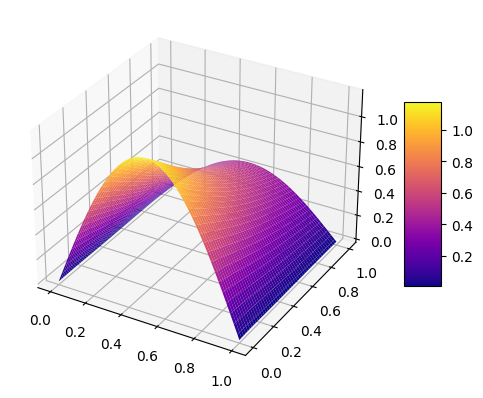

In [66]:
# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, U_pred, cmap='plasma')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [67]:
def exact_sol(X_star):
  x = X_star[:,0:1]
  t = X_star[:,1:2]
  return np.exp(-t)*np.sin(np.pi*x)

In [68]:
U_exact = exact_sol(X_star0)
U_exact = np.reshape(U_exact,(2500, 100))

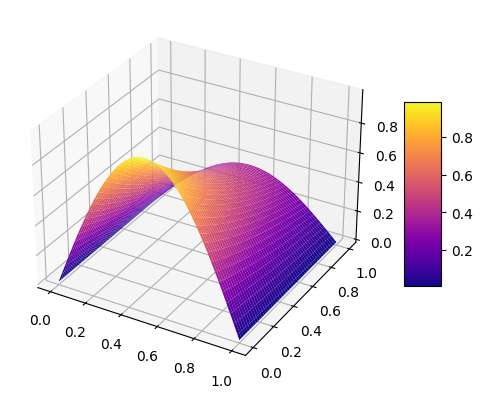

In [69]:
# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, U_exact, cmap='plasma')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
